<h1>Capstone Week 2- The Battle of the Neighborhoods | Notebook</h3>

<h4>*For simplicity's sake, I will be using the Toronto Wikipedia page from previous projects in the course*</h4>

<h2>1) Import Libraries</h2>

In [1]:
!pip install geocoder
!pip install folium

In [4]:
import pandas as pd
import requests
import numpy as np
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("All Required Libraries Imported!")


All Required Libraries Imported!


<h2>2) Data Extraction/Cleaning</h2>

In [5]:
List_url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
source = requests.get(List_url).text

In [6]:
soup = BeautifulSoup(source, 'xml')

In [7]:
table=soup.find('table')

In [8]:
column_names = ['Postalcode','Borough','Neighborhood']
df = pd.DataFrame(columns = column_names)

In [9]:
for tr_cell in table.find_all('tr'):
    row_data=[]
    for td_cell in tr_cell.find_all('td'):
        row_data.append(td_cell.text.strip())
    if len(row_data)==3:
        df.loc[len(df)] = row_data

In [10]:
df.head()

,Postalcode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [11]:
df=df[df['Borough']!='Not assigned']
df.head()

,Postalcode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [12]:
temp_df=df.groupby('Postalcode')['Neighborhood'].apply(lambda x: "%s" % ', '.join(x))
temp_df=temp_df.reset_index(drop=False)
temp_df.rename(columns={'Neighborhood':'Neighborhood_joined'},inplace=True)

In [13]:
df_merge = pd.merge(df, temp_df, on='Postalcode')

In [14]:
df_merge.drop(['Neighborhood'],axis=1,inplace=True)

In [15]:
df_merge.drop_duplicates(inplace=True)

In [16]:
df_merge.rename(columns={'Neighborhood_joined':'Neighborhood'},inplace=True)

In [17]:
df_merge.describe()

,Postalcode,Borough,Neighborhood
count,103,103,103
unique,103,10,99
top,M8V,North York,Downsview
freq,1,24,4


In [18]:
df_merge.head()

,Postalcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [19]:
df_merge.shape

(103, 3)

In [20]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
    
get_latilong('M4G')

[43.70909000000006, -79.36409999999995]

In [21]:
postal_codes = df_merge['Postalcode']    
coords = [ get_latilong(postal_code) for postal_code in postal_codes.tolist() ]

In [22]:
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df_merge['Latitude'] = df_coords['Latitude']
df_merge['Longitude'] = df_coords['Longitude']

In [23]:
df_merge[df_merge.Postalcode == 'M5G']

,Postalcode,Borough,Neighborhood,Latitude,Longitude
24,M5G,Downtown Toronto,Central Bay Street,43.65609,-79.38493


In [24]:
df_merge.head(12)

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.75188,-79.33036
1,M4A,North York,Victoria Village,43.73042,-79.31282
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65514,-79.36265
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72321,-79.45141
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.66449,-79.39302
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.66277,-79.52831
6,M1B,Scarborough,"Malvern, Rouge",43.81153,-79.19552
7,M3B,North York,Don Mills,43.74929,-79.36169
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.70794,-79.31160
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.65736,-79.37818


In [25]:
address = 'Scarborough,Toronto'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The Geograpical Co-ordinate of Lincoln,Nebraska are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Lincoln,Nebraska are 43.773077, -79.257774.


<h2>3) Creating Map</h2>

In [26]:
map_Scarborough = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

for lat, lng, nei in zip(df_merge['Latitude'], df_merge['Longitude'], df_merge['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Scarborough)  
    
map_Scarborough

In [26]:
address = 'Scarborough,Toronto'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude_n1 = location.latitude
longitude_n1 = location.longitude
print('The Geograpical Co-ordinate of Neighborhood_1 are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Neighborhood_1 are 43.773077, -79.257774.


In [27]:
CLIENT_ID = 'P4I1TUKSSOGYLA1SX5M2BLGHJULTITWWFJHPRY43QBXP2RHM' # my Foursquare ID
CLIENT_SECRET = '4YZVUT1PJEQLGEYS5ALKA33A2BM3R0KGF5DLGUONA1OAMG3T' # my Foursquare secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: '+CLIENT_ID)
print('CLIENT_SECRET: '+CLIENT_SECRET)

Your credentails:
CLIENT_ID: P4I1TUKSSOGYLA1SX5M2BLGHJULTITWWFJHPRY43QBXP2RHM
CLIENT_SECRET: 4YZVUT1PJEQLGEYS5ALKA33A2BM3R0KGF5DLGUONA1OAMG3T


In [71]:
radius = 500 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_n1, 
   longitude_n1, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [81]:
venues=results['response']['groups'][0]['items']
diff_venues = json_normalize(venues)
diff_venues.columns

Index(['reasons.count', 'reasons.items', 'referralId', 'venue.categories',
       'venue.events.count', 'venue.events.summary', 'venue.id',
       'venue.location.address', 'venue.location.cc', 'venue.location.city',
       'venue.location.country', 'venue.location.crossStreet',
       'venue.location.distance', 'venue.location.formattedAddress',
       'venue.location.labeledLatLngs', 'venue.location.lat',
       'venue.location.lng', 'venue.location.neighborhood',
       'venue.location.postalCode', 'venue.location.state', 'venue.name',
       'venue.photos.count', 'venue.photos.groups', 'venue.venuePage.id'],
      dtype='object')

In [82]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

<h2>4) Nearby Locations</h2>

In [83]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
diff_venues =diff_venues.loc[:, filtered_columns]
diff_venues.head(11)

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,SEPHORA,"[{'id': '4bf58dd8d48988d10c951735', 'name': 'C...",43.775017,-79.258109
1,Disney Store,"[{'id': '4bf58dd8d48988d1f3941735', 'name': 'T...",43.775537,-79.256833
2,American Eagle Store,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.776012,-79.258334
3,DAVIDsTEA,"[{'id': '4bf58dd8d48988d1dc931735', 'name': 'T...",43.776320,-79.258688
4,Tommy Hilfiger,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.776015,-79.257369
5,Chipotle Mexican Grill,"[{'id': '4bf58dd8d48988d1c1941735', 'name': 'M...",43.776410,-79.258069
6,St. Louis Bar & Grill,"[{'id': '4bf58dd8d48988d116941735', 'name': 'B...",43.774157,-79.253808
7,Hot Topic,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.775450,-79.257929
8,St. Andrews Fish & Chips,"[{'id': '4edd64a0c7ddd24ca188df1a', 'name': 'F...",43.771865,-79.252645
9,Shoppers Drug Mart,"[{'id': '4bf58dd8d48988d10f951735', 'name': 'P...",43.773305,-79.251662


In [84]:
diff_venues['venue.categories'] = diff_venues.apply(get_category_type, axis=1)

diff_venues.columns = [col.split(".")[-1] for col in diff_venues.columns]

diff_venues.head(11)

,name,categories,lat,lng
0,SEPHORA,Cosmetics Shop,43.775017,-79.258109
1,Disney Store,Toy / Game Store,43.775537,-79.256833
2,American Eagle Store,Clothing Store,43.776012,-79.258334
3,DAVIDsTEA,Tea Room,43.776320,-79.258688
4,Tommy Hilfiger,Clothing Store,43.776015,-79.257369
5,Chipotle Mexican Grill,Mexican Restaurant,43.776410,-79.258069
6,St. Louis Bar & Grill,Bar,43.774157,-79.253808
7,Hot Topic,Clothing Store,43.775450,-79.257929
8,St. Andrews Fish & Chips,Fish & Chips Shop,43.771865,-79.252645
9,Shoppers Drug Mart,Pharmacy,43.773305,-79.251662


In [85]:
a=pd.Series(diff_venues.categories)
a.value_counts()[:10]

Clothing Store            9
Coffee Shop               3
Tea Room                  2
Pharmacy                  2
Sandwich Place            2
Fish & Chips Shop         1
Toy / Game Store          1
American Restaurant       1
Bar                       1
Furniture / Home Store    1
Name: categories, dtype: int64

In [86]:
def getDiffVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Type']
    
    return(nearby_venues)

In [87]:

Scarborough_venues = getDiffVenues(names=df_merge['Neighborhood'],
                                   latitudes=df_merge['Latitude'],
                                   longitudes=df_merge['Longitude'])

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

In [115]:
print('There are {} Uniques Categories.'.format(len(Scarborough_venues['Venue Type'].unique())))
Scarborough_venues.groupby('Neighborhood').count().head(11)

There are 260 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Type
Neighborhood,,,,,,
Agincourt,8,8,8,8,8,8
"Alderwood, Long Branch",6,6,6,6,6,6
"Bathurst Manor, Wilson Heights, Downsview North",3,3,3,3,3,3
Bayview Village,3,3,3,3,3,3
"Bedford Park, Lawrence Manor East",22,22,22,22,22,22
Berczy Park,68,68,68,68,68,68
"Birch Cliff, Cliffside West",5,5,5,5,5,5
"Brockton, Parkdale Village, Exhibition Place",86,86,86,86,86,86
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",100,100,100,100,100,100


<h2>5) One Hot encoding</h2>

In [90]:
Scarborough_onehot = pd.get_dummies(Scarborough_venues[['Venue Type']], prefix="", prefix_sep="")

Scarborough_onehot['Neighborhood'] = Scarborough_venues['Neighborhood'] 

fixed_columns = [Scarborough_onehot.columns[-1]] + list(Scarborough_onehot.columns[:-1])
Scarborough_onehot = Scarborough_onehot[fixed_columns]
Scarborough_grouped = Scarborough_onehot.groupby('Neighborhood').mean().reset_index()
Scarborough_onehot.head(5)

,Zoo Exhibit,Accessories Store,Afghan Restaurant,Airport,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bike Trail,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Campground,Candy Store,Caribbean Restaurant,Carpet Store,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Climbing Spot,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [91]:
num_top_venues = 5
for hood in Scarborough_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =Scarborough_grouped[Scarborough_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Agincourt ----
             venue  freq
0             Pool  0.12
1             Park  0.12
2  Badminton Court  0.12
3     Skating Rink  0.12
4    Shopping Mall  0.12


---- Alderwood, Long Branch ----
                venue  freq
0   Convenience Store  0.17
1  Athletics & Sports  0.17
2         Pizza Place  0.17
3      Sandwich Place  0.17
4                 Gym  0.17


---- Bathurst Manor, Wilson Heights, Downsview North ----
                    venue  freq
0             IT Services  0.33
1  Furniture / Home Store  0.33
2                    Park  0.33
3             Zoo Exhibit  0.00
4                  Museum  0.00


---- Bayview Village ----
                        venue  freq
0  Construction & Landscaping  0.33
1                        Park  0.33
2                       Trail  0.33
3                 Zoo Exhibit  0.00
4  Modern European Restaurant  0.00


---- Bedford Park, Lawrence Manor East ----
                venue  freq
0  Italian Restaurant  0.14
1      Sandwich Place  0.09
2

                                      venue  freq
0                                   Dog Run   0.5
1  Residential Building (Apartment / Condo)   0.5
2                               Zoo Exhibit   0.0
3                               Men's Store   0.0
4                             Metro Station   0.0


---- Humber Summit ----
                        venue  freq
0  Construction & Landscaping  0.33
1                   BBQ Joint  0.33
2      Furniture / Home Store  0.33
3                 Zoo Exhibit  0.00
4         Monument / Landmark  0.00


---- Humberlea, Emery ----
                             venue  freq
0                      Coffee Shop  0.50
1                        Nightclub  0.25
2                             Park  0.25
3                      Zoo Exhibit  0.00
4  Molecular Gastronomy Restaurant  0.00


---- Humewood-Cedarvale ----
           venue  freq
0          Field  0.17
1   Hockey Arena  0.17
2           Park  0.17
3  Grocery Store  0.17
4    Coffee Shop  0.17


---- India B

                  venue  freq
0  Fast Food Restaurant  0.12
1    Chinese Restaurant  0.12
2              Pharmacy  0.06
3         Grocery Store  0.06
4       Bubble Tea Shop  0.06


---- Stn A PO Boxes ----
                venue  freq
0         Coffee Shop  0.10
1               Hotel  0.05
2  Italian Restaurant  0.04
3                 Bar  0.03
4    Asian Restaurant  0.03


---- Studio District ----
                venue  freq
0               Diner  0.08
1             Brewery  0.06
2  Italian Restaurant  0.06
3         Coffee Shop  0.06
4           Pet Store  0.04


---- Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park ----
                venue  freq
0         Coffee Shop  0.33
1  Light Rail Station  0.33
2        Liquor Store  0.17
3         Supermarket  0.17
4              Museum  0.00


---- The Annex, North Midtown, Yorkville ----
                           venue  freq
0             Italian Restaurant  0.10
1             Mexican Restaurant  0.07
2                 

<h2>6) Prevalent Locations</h2>

In [95]:
def return_most_prevalent_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [114]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Prevalent Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Prevalent Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Scarborough_grouped['Neighborhood']

for ind in np.arange(Scarborough_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_prevalent_venues(Scarborough_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(11)

,Neighborhood,1st Most Prevalent Venue,2nd Most Prevalent Venue,3rd Most Prevalent Venue,4th Most Prevalent Venue,5th Most Prevalent Venue,6th Most Prevalent Venue,7th Most Prevalent Venue,8th Most Prevalent Venue,9th Most Prevalent Venue,10th Most Prevalent Venue
0,Agincourt,Skating Rink,Pool,Badminton Court,Sushi Restaurant,Supermarket,Discount Store,Shopping Mall,Park,Elementary School,Electronics Store
1,"Alderwood, Long Branch",Gym,Pizza Place,Convenience Store,Pub,Sandwich Place,Athletics & Sports,Yoga Studio,Dumpling Restaurant,Dog Run,Donut Shop
2,"Bathurst Manor, Wilson Heights, Downsview North",Park,IT Services,Furniture / Home Store,Yoga Studio,Dumpling Restaurant,Distribution Center,Dog Run,Donut Shop,Dry Cleaner,Electronics Store
3,Bayview Village,Trail,Park,Construction & Landscaping,Yoga Studio,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Sandwich Place,Thai Restaurant,Coffee Shop,Hobby Shop,Restaurant,Butcher,Indian Restaurant,Sports Club,Pub
5,Berczy Park,Coffee Shop,Restaurant,Café,Hotel,Lounge,Cheese Shop,Cocktail Bar,Seafood Restaurant,Italian Restaurant,Farmers Market
6,"Birch Cliff, Cliffside West",College Stadium,Café,Gym,Skating Rink,General Entertainment,Yoga Studio,Eastern European Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant
7,"Brockton, Parkdale Village, Exhibition Place",Café,Bar,Coffee Shop,Restaurant,Gift Shop,Sandwich Place,Breakfast Spot,Supermarket,Bakery,Lounge
8,"Business reply mail Processing Centre, South C...",Coffee Shop,Hotel,Italian Restaurant,Asian Restaurant,Restaurant,Bar,Café,Sushi Restaurant,Pub,Concert Hall
9,"CN Tower, King and Spadina, Railway Lands, Har...",Coffee Shop,Italian Restaurant,Café,Gym / Fitness Center,Bar,Speakeasy,Bakery,Restaurant,Train Station,Electronics Store


<h2>7) K-Means Clustering</h2>

In [112]:
Scarborough_grouped_clustering = Scarborough_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(Scarborough_grouped_clustering)
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [113]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Scarborough_merged =df_merge.iloc[:16,:]

Scarborough_merged = Scarborough_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Scarborough_merged.head(11)

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Prevalent Venue,2nd Most Prevalent Venue,3rd Most Prevalent Venue,4th Most Prevalent Venue,5th Most Prevalent Venue,6th Most Prevalent Venue,7th Most Prevalent Venue,8th Most Prevalent Venue,9th Most Prevalent Venue,10th Most Prevalent Venue
0,M3A,North York,Parkwoods,43.75188,-79.33036,0,Pet Store,Park,Food & Drink Shop,Falafel Restaurant,Farm,Event Space,Ethiopian Restaurant,Elementary School,Diner,Electronics Store
1,M4A,North York,Victoria Village,43.73042,-79.31282,0,Nail Salon,Intersection,Grocery Store,Eastern European Restaurant,Distribution Center,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Electronics Store
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65514,-79.36265,0,Coffee Shop,Breakfast Spot,Theater,Event Space,Electronics Store,Spa,Food Truck,Restaurant,Italian Restaurant,Distribution Center
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72321,-79.45141,0,Clothing Store,Furniture / Home Store,Food Court,Sushi Restaurant,Women's Store,Toy / Game Store,Bookstore,American Restaurant,Coffee Shop,Cosmetics Shop
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.66449,-79.39302,0,Coffee Shop,Sandwich Place,Park,Café,Persian Restaurant,Cocktail Bar,Salon / Barbershop,Pub,Chinese Restaurant,Burger Joint
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.66277,-79.52831,0,Pharmacy,Park,Café,Shopping Mall,Bank,Skating Rink,Grocery Store,Ethiopian Restaurant,Elementary School,Discount Store
6,M1B,Scarborough,"Malvern, Rouge",43.81153,-79.19552,0,Zoo Exhibit,Home Service,Elementary School,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant
7,M3B,North York,Don Mills,43.74929,-79.36169,0,Coffee Shop,Clothing Store,Gas Station,Gym,Supermarket,Park,Burger Joint,Spa,Intersection,Beer Store
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.70794,-79.31160,0,Pizza Place,Gym / Fitness Center,Athletics & Sports,Pet Store,Pharmacy,Rock Climbing Spot,Café,Fast Food Restaurant,Breakfast Spot,Bank
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.65736,-79.37818,0,Coffee Shop,Clothing Store,Café,Japanese Restaurant,Cosmetics Shop,Middle Eastern Restaurant,Bookstore,Bubble Tea Shop,Movie Theater,Bar


In [116]:
kclusters = 10

<h2>8) Cluster Map</h2>

In [117]:
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)

x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)

markers_colors = []
for lat, lon, nei , cluster in zip(Scarborough_merged['Latitude'], 
                                   Scarborough_merged['Longitude'], 
                                   Scarborough_merged['Neighborhood'], 
                                   Scarborough_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


In [118]:
df1=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 0,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df2=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 1,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df3=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 2,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]

<h2>9) House Prices in Scarborough</h2>

In [144]:
Scarborough_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df_merge["Neighborhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                                               279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
                                                               573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               573900.0,425000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,195000.0,370500.,255400.0,403500.0,433500.0,335000.0,286600.0,187000.0,225900.0,219400.0,
                                                               573900.0,325000.0,370500.0,370500.0,333500.0,279200.0,
                                                               279200.0,289000.0,370500.,255400.0,413500.0,433500.0,254800.0]})

In [145]:
Scarborough_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)

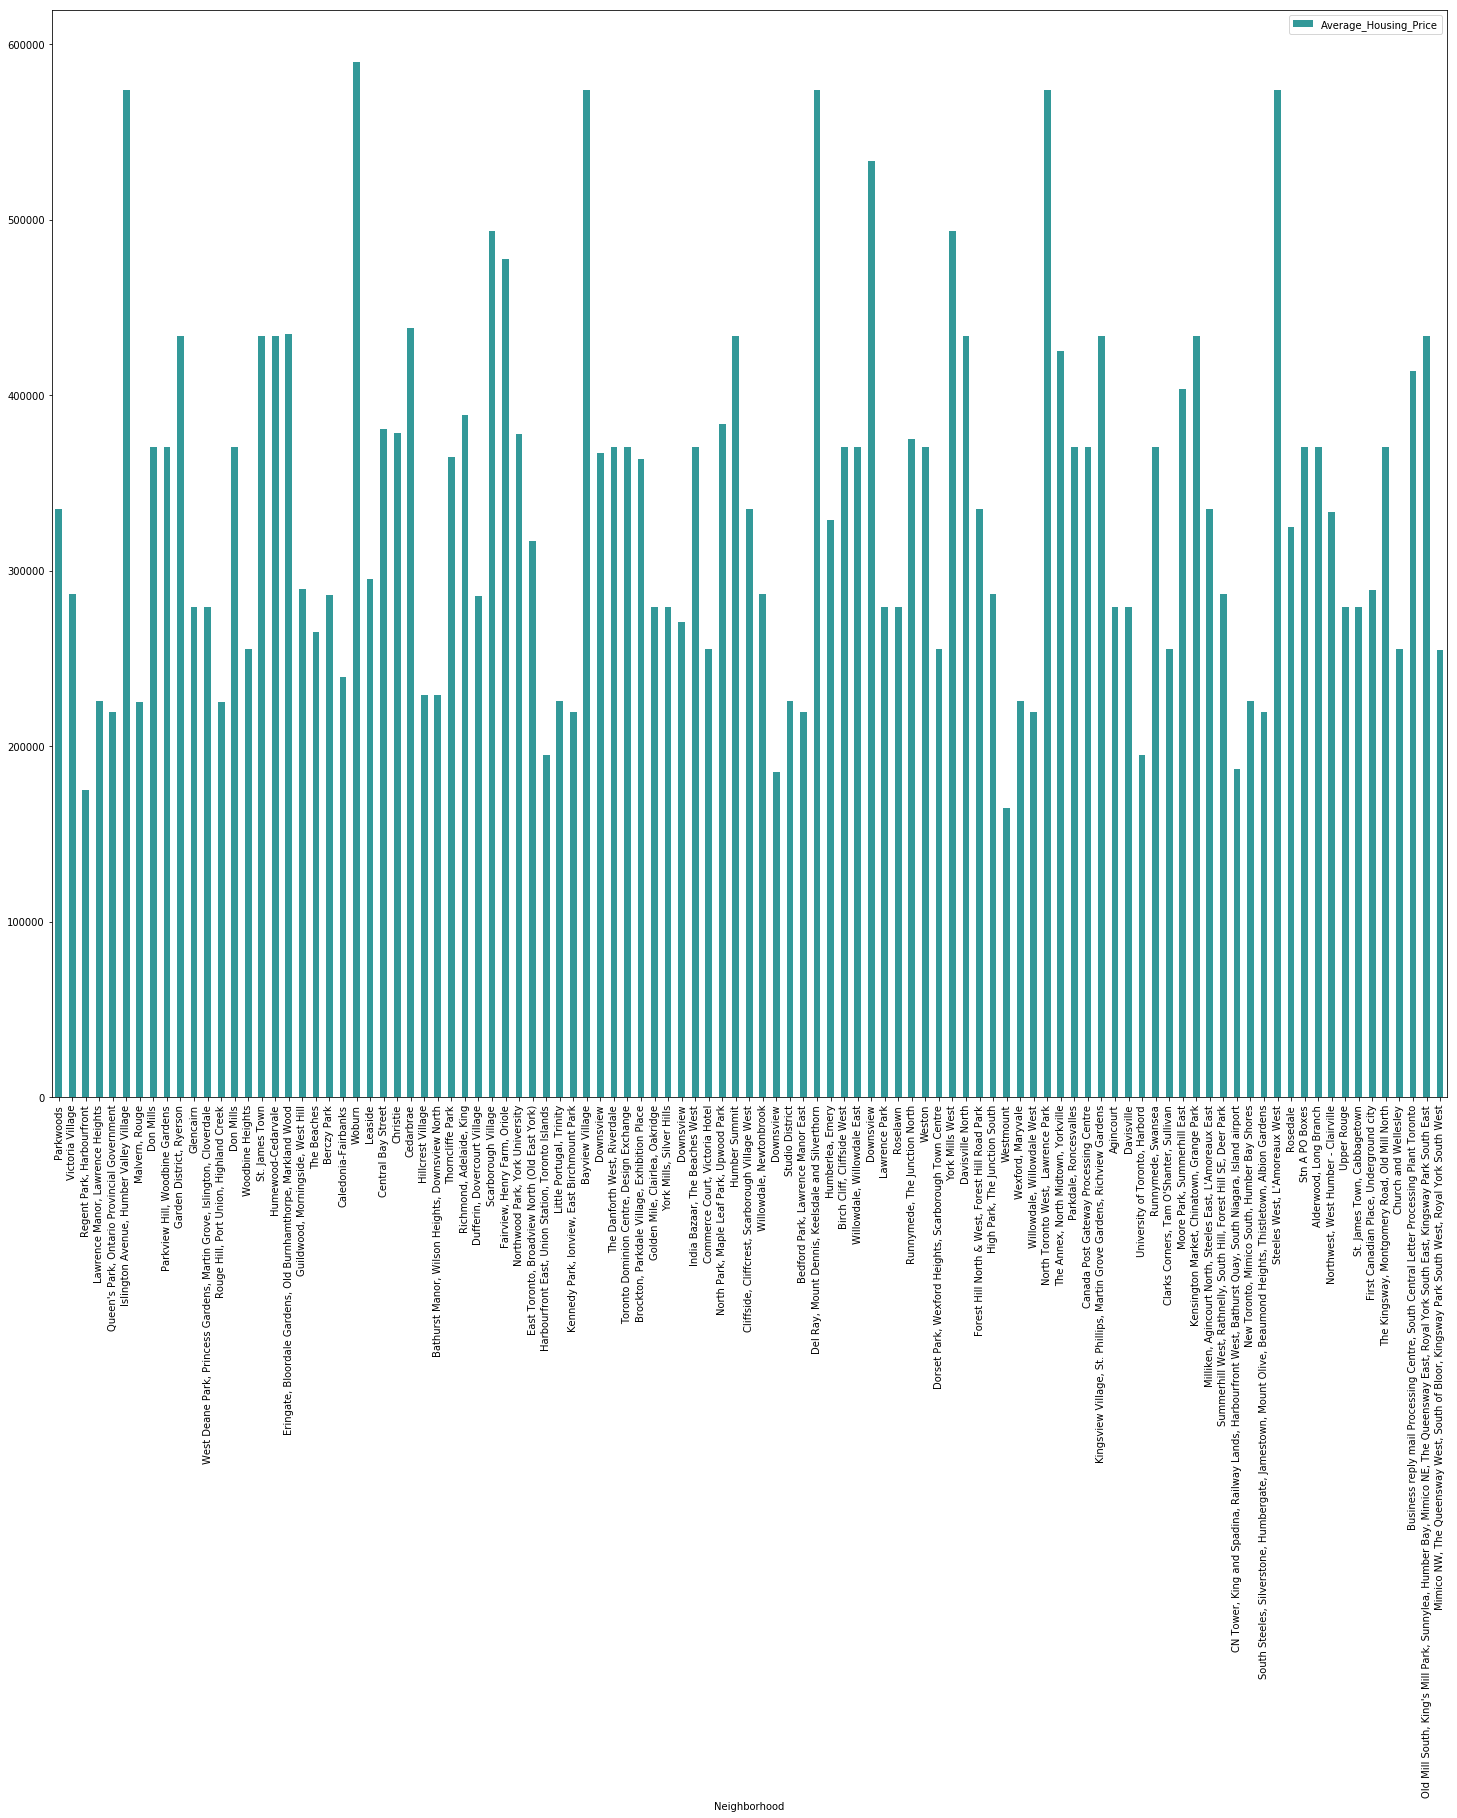

In [153]:
Scarborough_Avg_HousingPrice.plot(kind='bar',figsize=(25,20),color='teal', alpha=0.8)